In [584]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Загрузка данных

In [585]:
beer_sales_data = pd.read_parquet('Data/beer_sales_data.parquet')
cig_sales_data = pd.read_parquet('Data/cig_sales_data.parquet')
ana_sales_data = pd.read_parquet('Data/ana_sales_data.parquet')

# Удаляем `not important` колонки из **upc** таблиц
upc_cols2drop = ['com_code', 'case']
beer_upc = pd.read_parquet('Data/beer_upc.parquet').drop(columns=upc_cols2drop)
cig_upc = pd.read_parquet('Data/cig_upc.parquet').drop(columns=upc_cols2drop)
ana_upc = pd.read_parquet('Data/ana_upc.parquet').drop(columns=upc_cols2drop)

demographic_data = pd.read_parquet('Data/demographic_data.parquet')

weeks_data = pd.read_csv('Data/weeks_data.csv')

## EDA beer_sales

In [586]:
beer_sales_data.head()

,store,upc,week,move,qty,price,sale
0,2,294,298,11,1,2.62,None
1,2,294,299,9,1,2.51,None
2,2,294,300,6,1,2.49,None
3,2,294,301,5,1,2.99,None
4,2,294,302,1,1,2.49,None


### Работа с типами данных

In [587]:
beer_sales_data.dtypes

store      int64
upc        int64
week       int64
move       int64
qty        int64
price    float64
sale      object
dtype: object

Колонка **store** состоит из id магазинов, поэтому её можно считать типа **object**.  
Аналогичное имеет смысл сделать с **upc** и **week**

In [588]:
beer_sales_data = beer_sales_data.astype({'store': 'object', 'upc': 'object', 'week': 'object'})

### Работа с пропусками

In [589]:
beer_sales_data.isna().sum()

store          0
upc            0
week           0
move           0
qty            0
price          0
sale     3420284
dtype: int64

Единственные `None` значения присутствуют в столбце **sale**.  
В силу того, что **sale** равный `None` означает продажу без скидки, то заменим на `N`

In [590]:
beer_sales_data.fillna({'sale': 'N'}, inplace=True)

### Работа с числовыми признаками

In [591]:
beer_sales_data.describe()

,move,qty,price
count,3.967720e+06,3.967720e+06,3.967720e+06
mean,3.383864e+00,1.000011e+00,2.819041e+00
std,8.877261e+00,3.330071e-03,3.422010e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00
75%,3.000000e+00,1.000000e+00,4.990000e+00
max,7.690000e+02,2.000000e+00,2.964000e+01


Посмотрим коэффициенты вариации для соответствующих колонок

In [592]:
beer_sales_std_desc = beer_sales_data.select_dtypes('number').apply(
    lambda x: (x.std(), x.std() / x.mean() * 100), axis=0)
beer_sales_std_desc.index = ['std', 'cv']
beer_sales_std_desc

,move,qty,price
std,8.877261,0.003330,3.422010
cv,262.340936,0.333003,121.389136


In [593]:
del beer_sales_std_desc

Можно заметить, что коэффициент вариации у всех колонок кроме **qty** > 30%.  
Поэтому проанализируем данный столбец.

In [594]:
beer_sales_data['qty'].value_counts()

qty
1    3967676
2         44
Name: count, dtype: int64

В силу того, что **qty** имеет только два уникальных значения, и одно из них есть только в 44 экземплярах среди почти 4 миллионов, можно убрать столбец в силу его квазиконстантности.

In [595]:
beer_sales_data.drop(columns=['qty'], inplace=True)

move        Axes(0.125,0.11;0.352273x0.77)
price    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

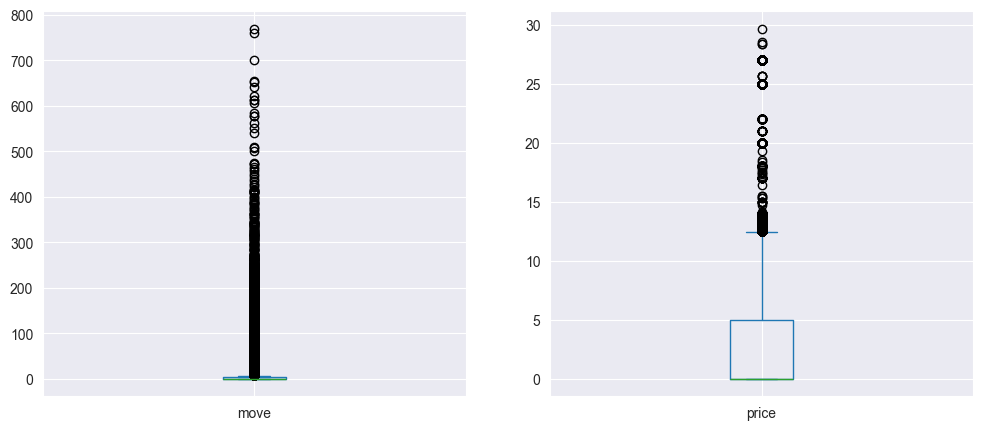

In [596]:
beer_sales_data.plot(kind='box',
                     subplots=True,
                     figsize=(12, 5),
                     sharex=False,
                     sharey=False)

Посмотрим на то, какой процент от всех занимают точки, лежащие за верхней границей.

In [597]:
beer_sales_move_Q1 = beer_sales_data['move'].quantile(0.25)
beer_sales_move_Q3 = beer_sales_data['move'].quantile(0.75)
beer_sales_move_IQR = beer_sales_move_Q3 - beer_sales_move_Q1
beer_sales_move_upper_whisker = beer_sales_move_Q3 + 1.5 * beer_sales_move_IQR
beer_sales_move_percent = ((beer_sales_data['move'] > beer_sales_move_upper_whisker).sum()
                           / beer_sales_data.shape[0] * 100)

beer_sales_price_Q1 = beer_sales_data['price'].quantile(0.25)
beer_sales_price_Q3 = beer_sales_data['price'].quantile(0.75)
beer_sales_price_IQR = beer_sales_price_Q3 - beer_sales_price_Q1
beer_sales_price_upper_whisker = beer_sales_price_Q3 + 1.5 * beer_sales_price_IQR
beer_sales_price_percent = ((beer_sales_data['price'] > beer_sales_price_upper_whisker).sum()
                            / beer_sales_data.shape[0] * 100)

print(f'move - {beer_sales_move_percent}', f'price - {beer_sales_price_percent}', sep='\n')

move - 12.122352383736755
price - 0.6224481566239554


In [598]:
del beer_sales_move_Q1
del beer_sales_move_Q3
del beer_sales_move_IQR
del beer_sales_move_upper_whisker
del beer_sales_move_percent

del beer_sales_price_Q1
del beer_sales_price_Q3
del beer_sales_price_IQR
del beer_sales_price_upper_whisker
del beer_sales_price_percent

В силу незначительного процента у **price** оставим их, а у **move** уберём те, что выше 99.5 квантиля.

In [599]:
# beer_sales_data = beer_sales_data[beer_sales_data['move'] <= beer_sales_data['move'].quantile(0.995)]

# удалять или не удалять???

move        Axes(0.125,0.11;0.352273x0.77)
price    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

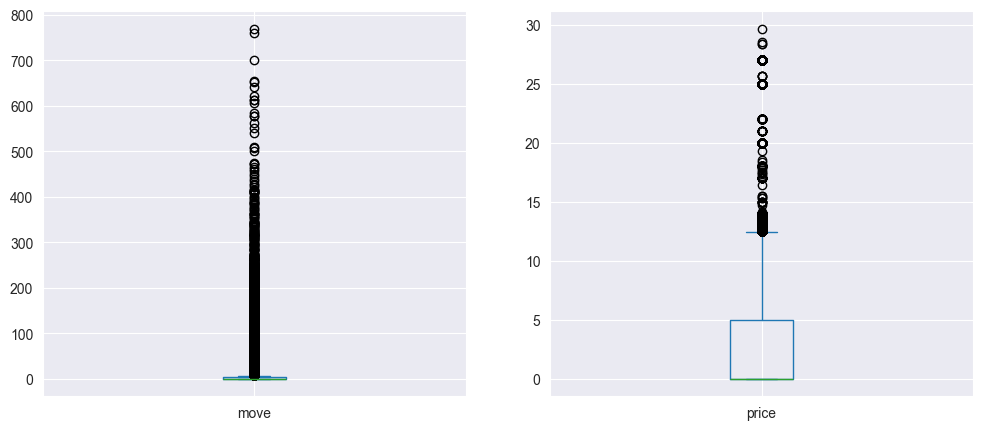

In [600]:
beer_sales_data.plot(kind='box',
                     subplots=True,
                     figsize=(12, 5),
                     sharex=False,
                     sharey=False)

Добавим признак **event**, говорящий о наличии праздников на неделе.

In [601]:
beer_sales_data = beer_sales_data.join(weeks_data[['week', 'event']].set_index('week'), how='inner', on='week')

In [602]:
beer_sales_data['event'].value_counts()

event
Labor Day         87235
4th of July       83750
Easter            76245
Halloween         74951
New-Year          73234
Christmas         73088
Thanksgiving      72506
Memorial Day      69669
Presidents Day    59007
Name: count, dtype: int64

Посмотрим на распределение количества продаж и суммы продаж по неделям в зависимости от праздника

In [603]:
beer_sales_amount_by_week = beer_sales_data.groupby('week').agg(
    sales_amount=pd.NamedAgg('move', 'sum')).reset_index()
beer_sales_amount_by_week.head()

,week,sales_amount
0,91,58515
1,92,70570
2,93,69579
3,94,70108
4,95,100298


In [604]:
beer_sales_amount_event_weeks = (
    weeks_data[(~weeks_data['event'].isna()) & (weeks_data['week'] >= beer_sales_amount_by_week['week'].min()) &
               (weeks_data['week'] <= beer_sales_amount_by_week['week'].max())]
    .groupby('event')['week']
    .apply(list)
    .to_dict()
)
beer_sales_amount_event_weeks

{'4th of July': [95, 147, 199, 251, 303, 356],
 'Christmas': [119, 172, 224, 276, 328, 380],
 'Easter': [133, 185, 238, 289, 341, 393],
 'Halloween': [112, 164, 216, 268, 320, 372],
 'Labor Day': [103, 156, 208, 260, 312, 364],
 'Memorial Day': [141, 194, 246, 298, 350],
 'New-Year': [120, 173, 225, 277, 329, 381],
 'Presidents Day': [128, 180, 232, 284, 336, 389],
 'Thanksgiving': [116, 168, 220, 272, 324, 377]}

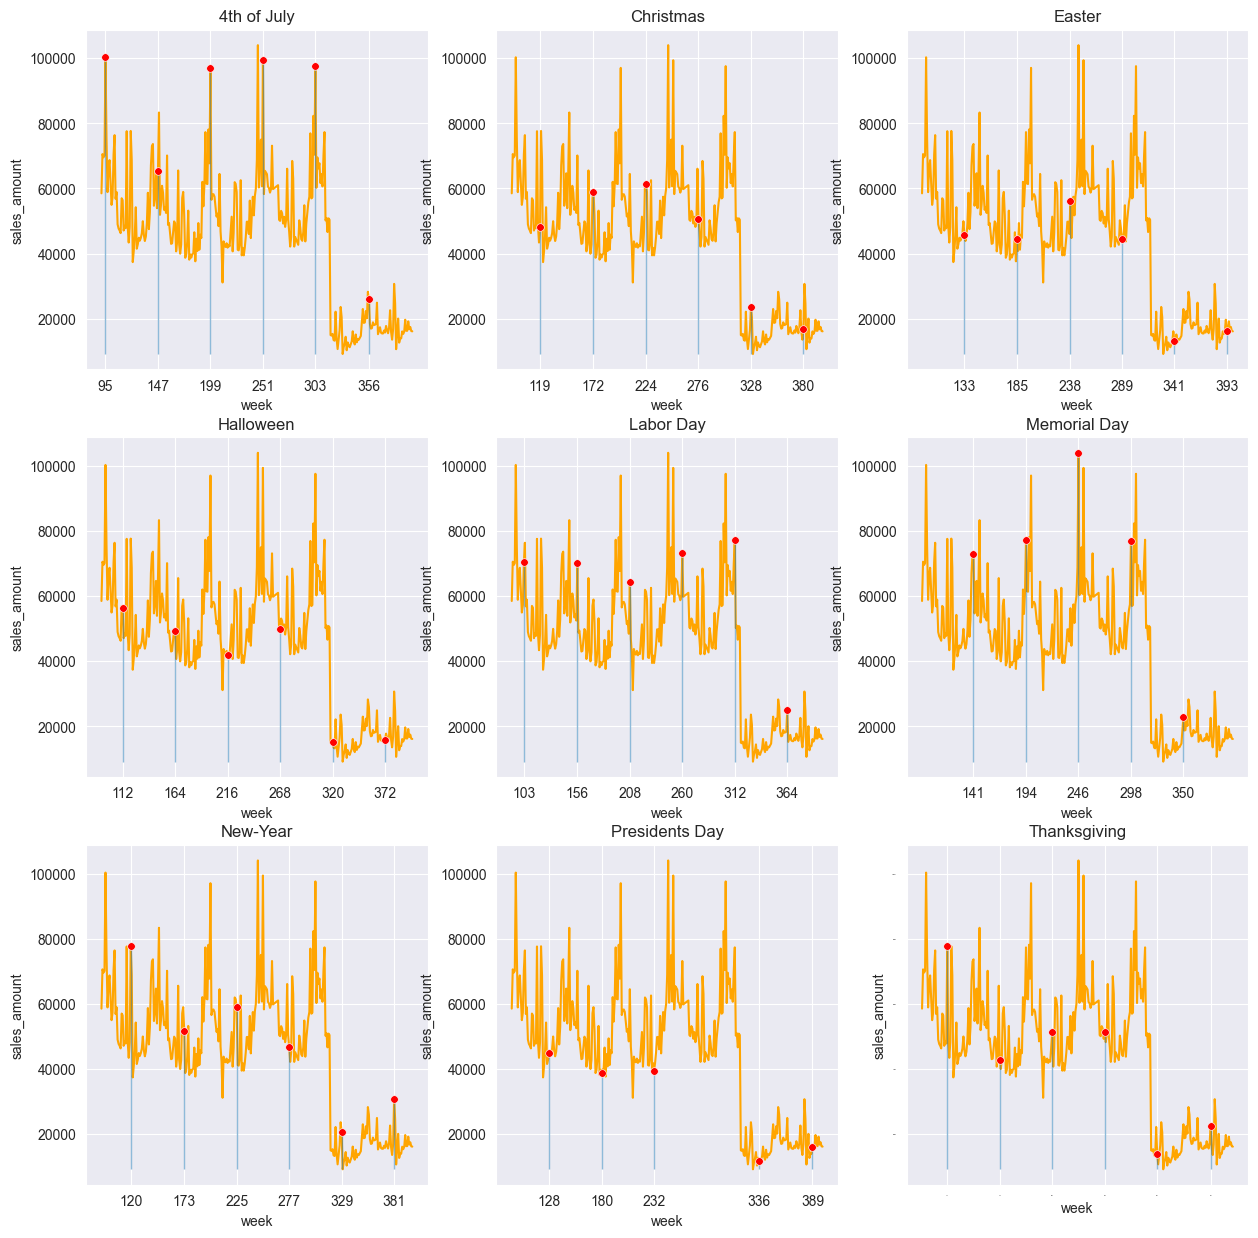

In [605]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

plt.xticks(fontsize=1)
plt.yticks(fontsize=1)

for i, (event, weeks) in enumerate(beer_sales_amount_event_weeks.items()):
    ax[i].set_title(event)

    sns.lineplot(ax=ax[i],
                 data=beer_sales_amount_by_week,
                 x='week',
                 y='sales_amount',
                 c='orange',
                 zorder=1)

    s = beer_sales_amount_by_week[beer_sales_amount_by_week['week'].isin(weeks)][['sales_amount', 'week']]

    ax[i].vlines(x=s['week'],
                 ymin=beer_sales_amount_by_week['sales_amount'].min(),
                 ymax=s['sales_amount'], zorder=2, linewidth=1, alpha=0.5)

    sns.scatterplot(ax=ax[i],
                    x=s['week'],
                    y=s['sales_amount'],
                    color='red',
                    zorder=3,
                    s=30)

    ax[i].set_xticks(s.week)

del s
del beer_sales_amount_by_week
del beer_sales_amount_event_weeks

Из графиков видно, что в большинство праздников люди покупают пиво больше, чем обычно.  
Хотя есть праздники, в которые количество продаж падает.

In [625]:
beer_sales_revenue = beer_sales_data.copy()
beer_sales_revenue['revenue'] = (beer_sales_revenue['move'] * beer_sales_revenue['price'])

beer_sales_revenue_by_week = beer_sales_revenue.groupby('week').agg(
    revenue=pd.NamedAgg('revenue', 'sum')).reset_index()
beer_sales_revenue_by_week.head()

,week,revenue
0,91,326527.45
1,92,373810.95
2,93,360063.02
3,94,397556.36
4,95,555812.86


In [607]:
beer_sales_revenue_event_weeks = (
    weeks_data[(~weeks_data['event'].isna()) & (weeks_data['week'] >= beer_sales_revenue_by_week['week'].min()) &
               (weeks_data['week'] <= beer_sales_revenue_by_week['week'].max())]
    .groupby('event')['week']
    .apply(list)
    .to_dict()
)
beer_sales_revenue_event_weeks

{'4th of July': [95, 147, 199, 251, 303, 356],
 'Christmas': [119, 172, 224, 276, 328, 380],
 'Easter': [133, 185, 238, 289, 341, 393],
 'Halloween': [112, 164, 216, 268, 320, 372],
 'Labor Day': [103, 156, 208, 260, 312, 364],
 'Memorial Day': [141, 194, 246, 298, 350],
 'New-Year': [120, 173, 225, 277, 329, 381],
 'Presidents Day': [128, 180, 232, 284, 336, 389],
 'Thanksgiving': [116, 168, 220, 272, 324, 377]}

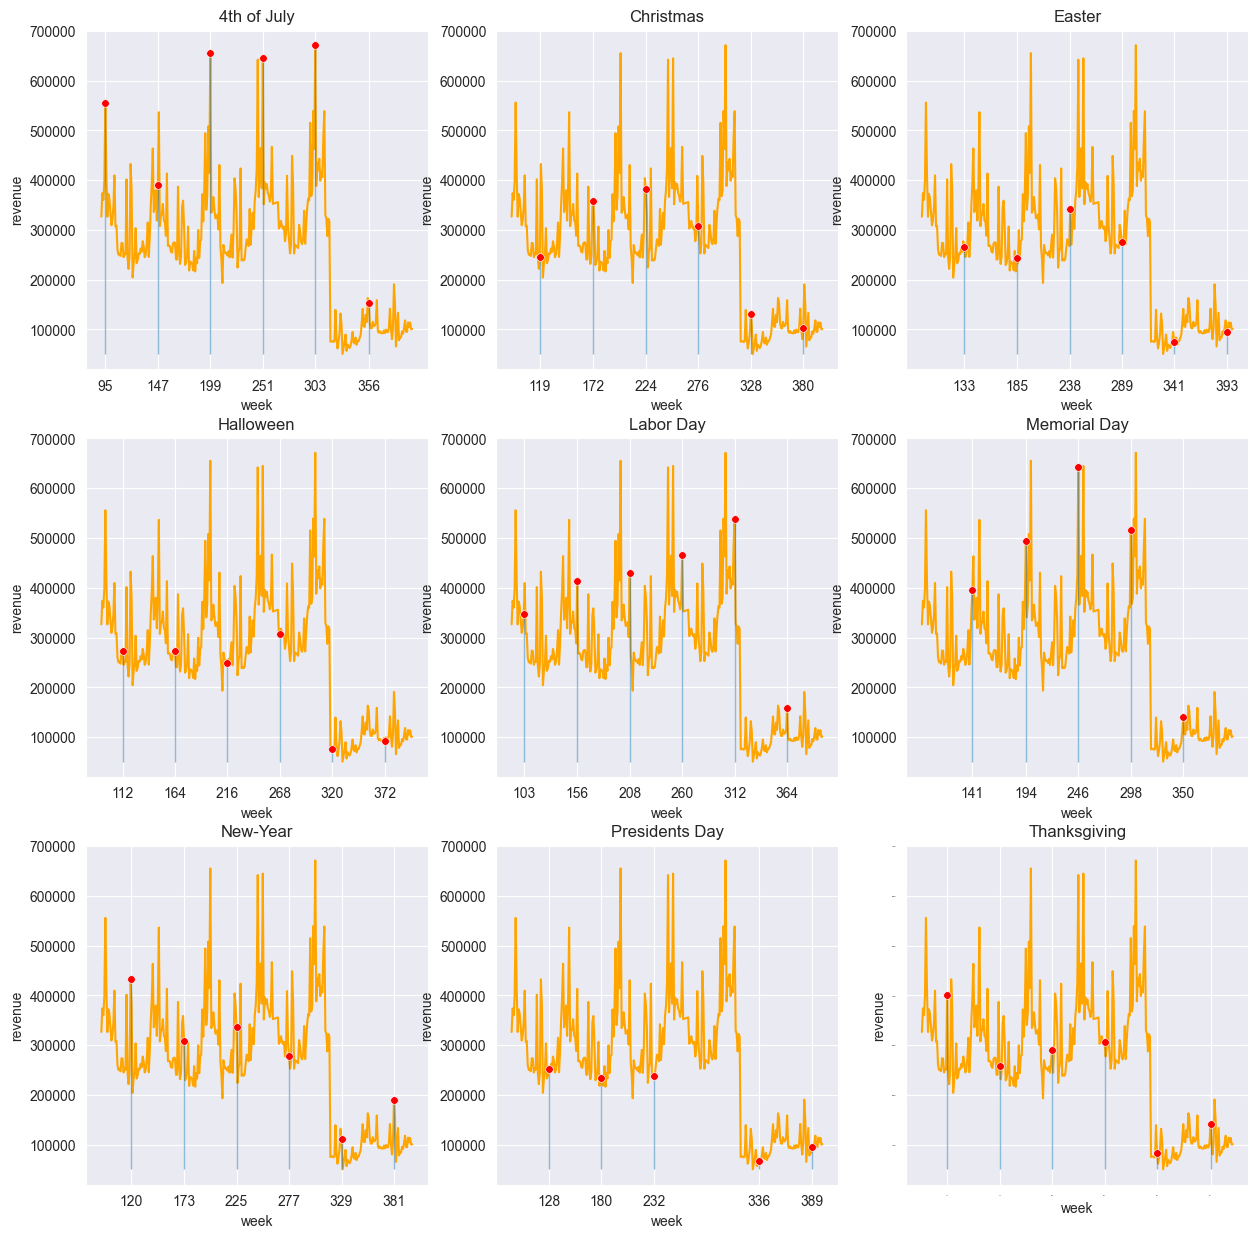

In [608]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

plt.xticks(fontsize=1)
plt.yticks(fontsize=1)

for i, (event, weeks) in enumerate(beer_sales_revenue_event_weeks.items()):
    ax[i].set_title(event)

    sns.lineplot(ax=ax[i],
                 data=beer_sales_revenue_by_week,
                 x='week',
                 y='revenue',
                 c='orange',
                 zorder=1)

    s = beer_sales_revenue_by_week[beer_sales_revenue_by_week['week'].isin(weeks)][
        ['revenue', 'week']]

    ax[i].vlines(x=s['week'],
                 ymin=beer_sales_revenue_by_week['revenue'].min(),
                 ymax=s['revenue'], zorder=2, linewidth=1, alpha=0.5)

    sns.scatterplot(ax=ax[i],
                    x=s['week'],
                    y=s['revenue'],
                    color='red',
                    zorder=3,
                    s=30)

    ax[i].set_xticks(s.week)

del s
del beer_sales_revenue_by_week
del beer_sales_revenue_event_weeks

Тут ситуация похожая на то, что было выше.

В силу того, что не каждый праздник увеличивает продажи (некоторые и уменьшают), добавим данные о праздниках, используя ohe

In [609]:
beer_sales_data = pd.concat([beer_sales_data.drop(columns=['event']),
                             pd.get_dummies(beer_sales_data['event'], drop_first=False, dummy_na=False)], axis=1)
beer_sales_data.head()

,store,upc,week,move,price,sale,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,Thanksgiving
0,2,294,298,11,2.62,N,False,False,False,False,False,True,False,False,False
1,2,294,299,9,2.51,N,False,False,False,False,False,False,False,False,False
2,2,294,300,6,2.49,N,False,False,False,False,False,False,False,False,False
3,2,294,301,5,2.99,N,False,False,False,False,False,False,False,False,False
4,2,294,302,1,2.49,N,False,False,False,False,False,False,False,False,False


Посмотрим на корреляции признаков

move         price           0.347112
             4th of July     0.039966
             Memorial Day    0.025617
4th of July  Labor Day      -0.022017
Easter       Labor Day      -0.020987
Halloween    Labor Day      -0.020805
Labor Day    New-Year       -0.020561
4th of July  Easter         -0.020554
Christmas    Labor Day      -0.020540
Labor Day    Thanksgiving   -0.020456
dtype: float64


<Axes: >

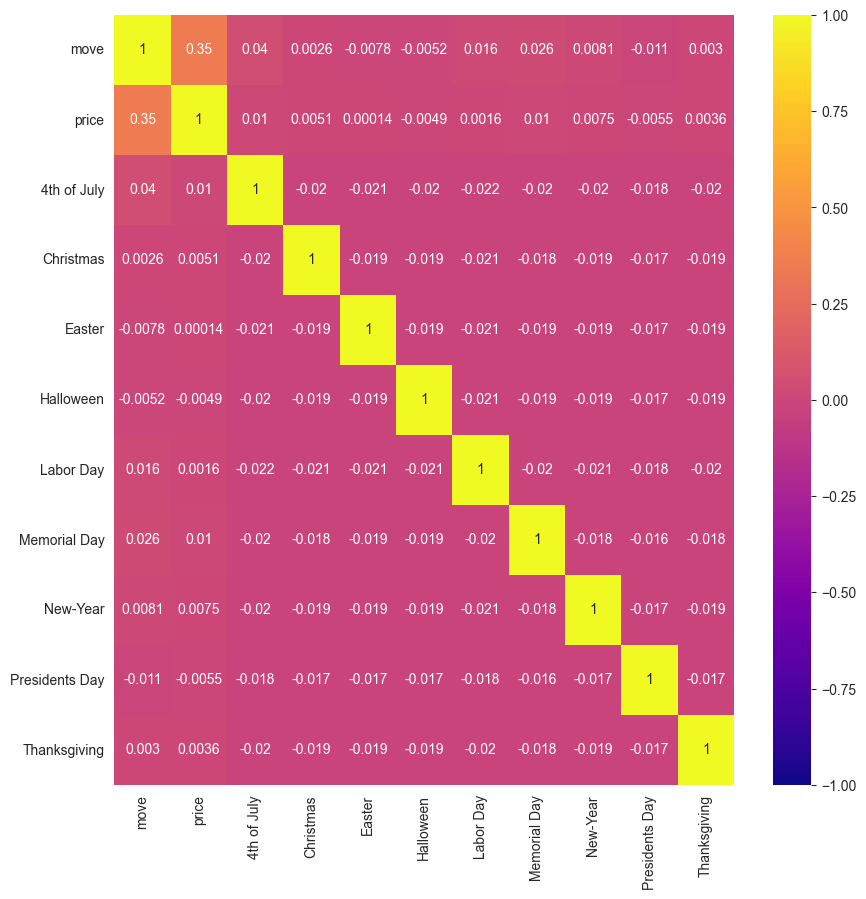

In [610]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(key=abs, ascending=False)
    return au_corr[0:n]


print(get_top_correlations(beer_sales_data.select_dtypes(['number', 'bool']), 10))

plt.figure(figsize=(10, 10))
sns.heatmap(beer_sales_data.select_dtypes(['number', 'bool']).corr(), annot=True, vmin=-1, vmax=1, cmap='plasma')

В силу того, что максимальная корреляция < 0.35, не будем удалять никаких столбцов.

### Работа с категориальными признаками

In [611]:
beer_sales_data.describe(include='object')

,store,upc,week,sale
count,3967720,3967720,3967720,3967720
unique,89,788,302,4
top,126,8066095605,317,N
freq,74757,21558,18517,3420284


Посмотрим на распределение **sale**

In [612]:
beer_sales_data['sale'].value_counts()

sale
N    3420284
B     537358
S       9745
C        333
Name: count, dtype: int64

### Изучение

Посмотрим на распределение **price** от **sale**

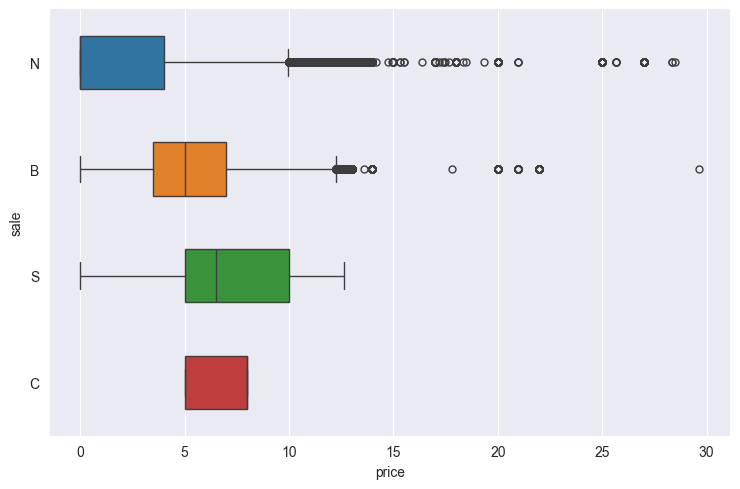

In [613]:
sns.catplot(data=beer_sales_data, x="price", y="sale", hue="sale", kind="box", height=5, aspect=1.5, width=0.5)

Посмотрим на распределение **move** от **sale**

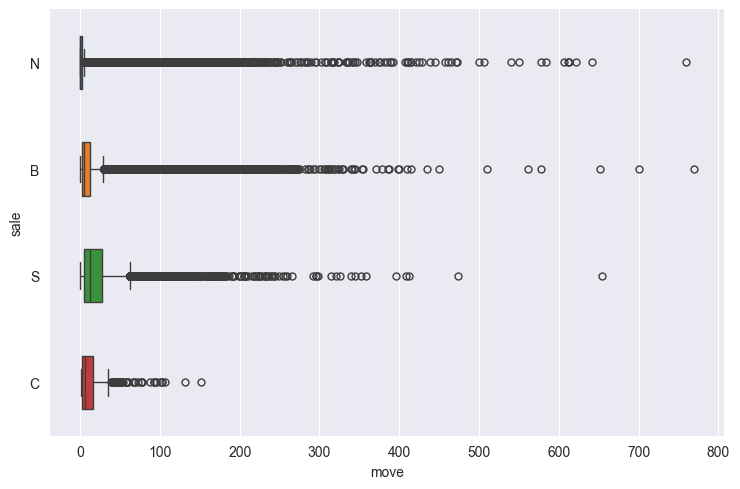

In [614]:
sns.catplot(data=beer_sales_data, x="move", y="sale", hue="sale", kind="box", height=5, aspect=1.5, width=0.5)

Можно заметить, что на обоих графиках видно достаточно большое количество выбросов. Пока оставим их #TODO 

Найдёт топ 10 лучших и худших магазинов по сумме продаже за всё время

In [626]:
beer_sales_revenue

,store,upc,week,move,price,sale,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,Thanksgiving,revenue
0,2,294,298,11,2.62,N,False,False,False,False,False,True,False,False,False,28.82
1,2,294,299,9,2.51,N,False,False,False,False,False,False,False,False,False,22.59
2,2,294,300,6,2.49,N,False,False,False,False,False,False,False,False,False,14.94
3,2,294,301,5,2.99,N,False,False,False,False,False,False,False,False,False,14.95
4,2,294,302,1,2.49,N,False,False,False,False,False,False,False,False,False,2.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990667,136,79709638102,395,0,0.00,N,False,False,False,False,False,False,False,False,False,0.00
3990668,136,79709638102,396,0,0.00,N,False,False,False,False,False,False,False,False,False,0.00
3990669,136,79709638102,397,0,0.00,N,False,False,False,False,False,False,False,False,False,0.00
3990670,136,79709638102,398,0,0.00,N,False,False,False,False,False,False,False,False,False,0.00


In [645]:
beer_sales_shops_sales_amount = beer_sales_data.groupby('store').agg(
    total_sales=('price', 'sum')
).reset_index()

beer_sales_shops_sales_revenue = beer_sales_revenue.groupby('store').agg(
    total_revenue=('revenue', 'sum')
).reset_index()

beer_shops_top_10_sales_amount = beer_sales_shops_sales_amount.nlargest(10, 'total_sales')
beer_shops_top_10_sales_revenue = beer_sales_shops_sales_revenue.nlargest(10, 'total_revenue')

beer_shops_worst_10_sales_amount = beer_sales_shops_sales_amount.nsmallest(10, 'total_sales')
beer_shops_worst_10_sales_revenue = beer_sales_shops_sales_revenue.nsmallest(10, 'total_revenue')

<Axes: title={'center': 'Топ 10 по количеству продаж'}, xlabel='total_sales', ylabel='store'>

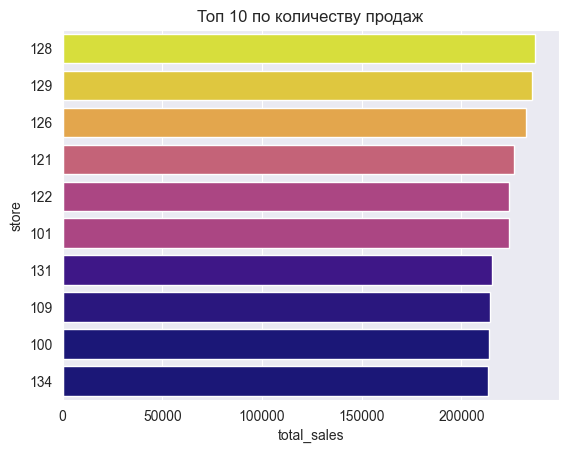

In [653]:
plt.title('Топ 10 по количеству продаж')
sns.barplot(data=beer_shops_top_10_sales_amount, y='store', hue='total_sales', x='total_sales',
            orient='h', legend=False, order=beer_shops_top_10_sales_amount['store'], palette='plasma')

<Axes: title={'center': 'Топ 10 по сумме продаж'}, xlabel='total_revenue', ylabel='store'>

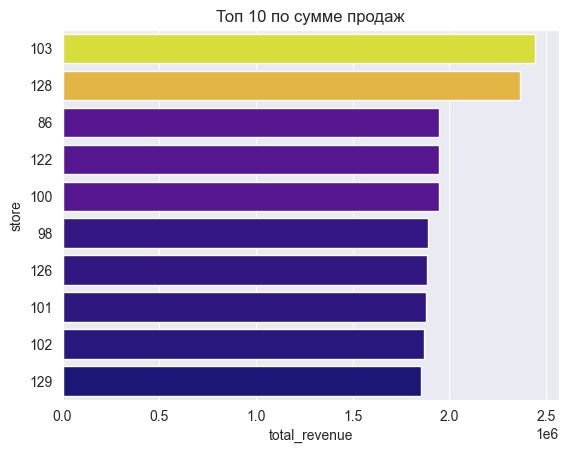

In [654]:
plt.title('Топ 10 по сумме продаж')
sns.barplot(data=beer_shops_top_10_sales_revenue, y='store', hue='total_revenue', x='total_revenue',
            orient='h', legend=False, order=beer_shops_top_10_sales_revenue['store'], palette='plasma')

,store,total_sales
44,92,2.49
13,47,4.99
14,48,9.78
8,28,12.57
12,44,15.32
37,83,17.16
0,2,34.64
40,88,9859.76
88,146,13879.68
85,142,17098.22


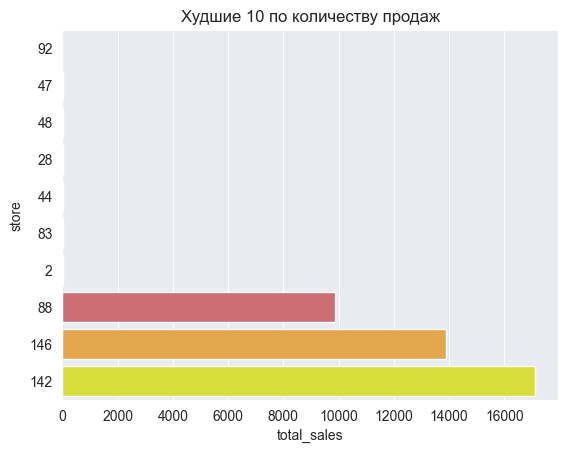

In [655]:
plt.title('Худшие 10 по количеству продаж')
sns.barplot(data=beer_shops_worst_10_sales_amount, y='store', hue='total_sales', x='total_sales',
            orient='h', legend=False, order=beer_shops_worst_10_sales_amount['store'], palette='plasma')
beer_shops_worst_10_sales_amount

<Axes: title={'center': 'Худшие 10 по сумме продаж'}, xlabel='total_revenue', ylabel='store'>

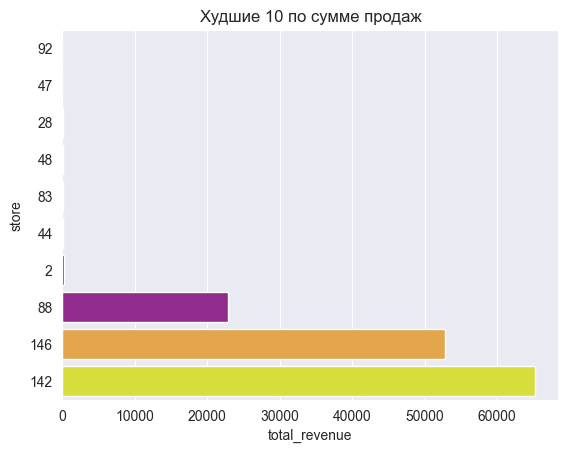

In [656]:
plt.title('Худшие 10 по сумме продаж')
sns.barplot(data=beer_shops_worst_10_sales_revenue, y='store', hue='total_revenue', x='total_revenue',
            orient='h', legend=False, order=beer_shops_worst_10_sales_revenue['store'], palette='plasma')

In [665]:
beer_sales_shops_sales_revenue['total_revenue'].describe()

count    8.900000e+01
mean     8.953608e+05
std      6.221066e+05
min      2.490000e+00
25%      4.178397e+05
50%      8.146373e+05
75%      1.256403e+06
max      2.441568e+06
Name: total_revenue, dtype: float64

In [666]:
del beer_sales_shops_sales_amount
del beer_sales_shops_sales_revenue
del beer_shops_top_10_sales_amount
del beer_shops_top_10_sales_revenue
del beer_shops_worst_10_sales_amount
del beer_shops_worst_10_sales_revenue

### Построение моделей

In [667]:
beer_full_data = (beer_sales_data
                  .join(beer_upc.set_index('upc'), how='inner', on='upc')
                  .join(demographic_data.set_index('store'), how='inner', on='store'))

cig_full_data = (beer_sales_data
                 .join(beer_upc.set_index('upc'), how='inner', on='upc')
                 .join(demographic_data.set_index('store'), how='inner', on='store'))

ana_full_data = (beer_sales_data
                 .join(beer_upc.set_index('upc'), how='inner', on='upc')
                 .join(demographic_data.set_index('store'), how='inner', on='store'))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000028C0E0E6950>>
Traceback (most recent call last):
  File "C:\Users\merku\.virtualenvs\MachineLearning-x7kuzlXN\lib\site-packages\ipykernel\ipkernel.py", line 788, in _clean_thread_parent_frames
    if phase != "start":
KeyboardInterrupt: 

KeyboardInterrupt

